In [3]:
import numpy as np
import pandas as pd 
from random import sample
import random
import itertools
import matplotlib.pyplot as plt
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# load data
sales = pd.read_csv("../data/sales_train_validation.csv")

In [6]:
# make time series columns integers for more meaningful plotting (can order numbers)
_cols = list(sales.columns)
sales.columns = pd.Index(_cols[:6] + [int(c.replace("d_","")) for c in _cols[6:]])
del _cols

In [7]:
def series_from_id(_id:str) -> pd.DataFrame:
    """
    Get a daily time series for a single id
    """
    return sales.loc[sales.id == _id]\
    .iloc[:,6:]\
    .T

# Create a global lookup table for fast plotting by department
daily_sales_dept_lookup = sales[["dept_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "dept_id")\
    .groupby("dept_id variable".split())\
    .agg({"value":"sum"})

def series_from_dept(dept:str) -> pd.DataFrame:
    return daily_sales_dept_lookup.loc[dept]

# create a global lookup table for fast plotting by item
daily_sales_item_lookup = sales[["item_id"] + list(sales.columns[6:])]\
    .melt(id_vars = "item_id")\
    .groupby("item_id variable".split())\
    .agg({"value":"sum"})

def series_from_item(item:str) -> pd.DataFrame:
    return daily_sales_item_lookup.loc[item]

"""
Time series for particular items are quite noisy on a daily level. 
Provide the ability to bin sales (for examply - to a weekly bin) for more stable plots
"""
def series_from_id_binned(_id:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an id, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_id(_id).reset_index()
    t["index"] = t.index.map(lambda x: x - (x % bin_every))
    t.columns = pd.Index(["day", "sales"])
    return t.groupby("day")\
        .agg({"sales":"sum"})

def series_from_dept_binned(dept:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for a department, grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_dept(dept).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

def series_from_item_binned(item:str, bin_every:int = 7) -> pd.DataFrame:
    """
    Get the sales for an item (across stores), grouped by a fixed interval (default 7 - weekly)
    """
    t = series_from_item(item).reset_index()
    t["variable"] = t.index.map(lambda x: x - (x % bin_every))
    return t.groupby("variable")\
        .agg({"value":"sum"})

---

## Dynamic Time Warping


Text(0.5, 0, 'Days since start')

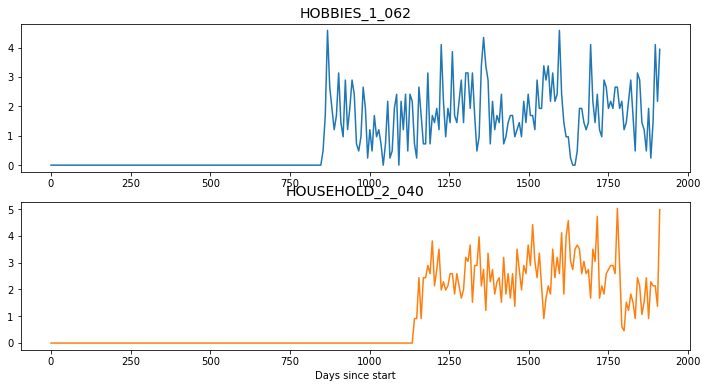

In [23]:
# show two series that look similar but are misaligned, for demonstration purposes
fig, [ax1,ax2] = plt.subplots(nrows = 2, figsize = (12,6))
daily_sales_item_lookup_scaled_weekly["HOBBIES_1_062"].plot(ax = ax1, color = "C0")
daily_sales_item_lookup_scaled_weekly["HOUSEHOLD_2_040"].plot(ax = ax2, color = "C1")
ax1.set_title("HOBBIES_1_062", fontsize= 14)
ax2.set_title("HOUSEHOLD_2_040", fontsize= 14)
ax1.set_xlabel("")
ax2.set_xlabel("Days since start")

In [25]:
def get_dtw_diff_matrix(cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = daily_sales_item_lookup_scaled_weekly[col1]
        series2 = daily_sales_item_lookup_scaled_weekly[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

In [50]:
# sample 50 series, and compute the DTW distance matrix
random.seed(1)
sample_cols = random.sample(list(daily_sales_item_lookup_scaled_weekly.columns), 150)
dtw_diff_dict = get_dtw_diff_matrix(sample_cols)
# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"item1", "level_1":"item2", 0:"diff"})\
    .pivot_table(index = "item1", columns = "item2", values = "diff")

/home/user/anaconda3/envs/py37/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


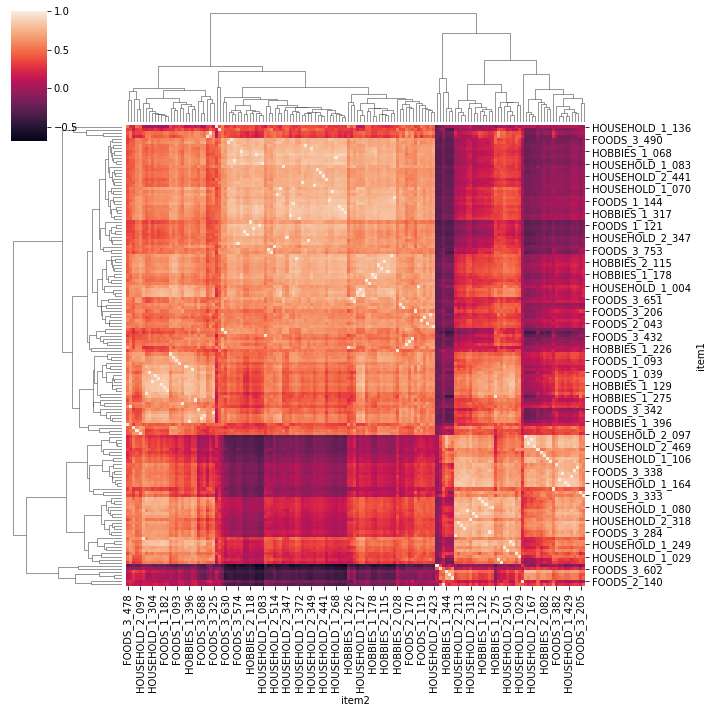

In [51]:
# plot a similarity matrix, with a dendogram imposed
import seaborn as sns
sns.clustermap(1-dtw_diff_df)

#### Extract clusters

Using this DTW distance matrix, we can perform heirarchical clustering and extract the clusters formed using this new distance function. 

In [52]:
# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
t = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(t, 1.15)}, index = dtw_diff_df.index)

Text(0.5, 1.0, 'Frequency of DTW clusters')

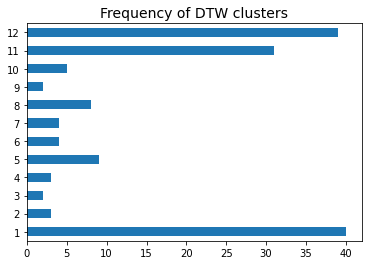

In [55]:
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title("Frequency of DTW clusters", fontsize = 14)

##### Loop over clusters

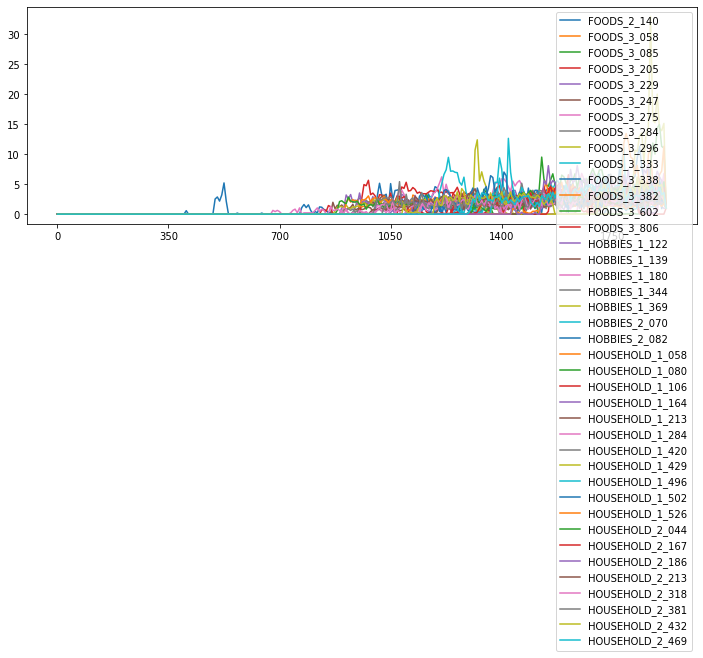

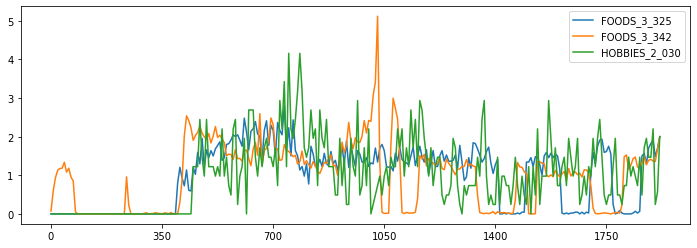

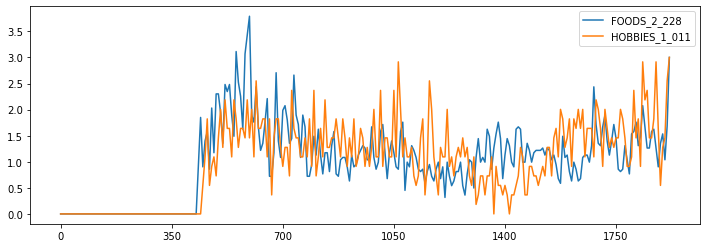

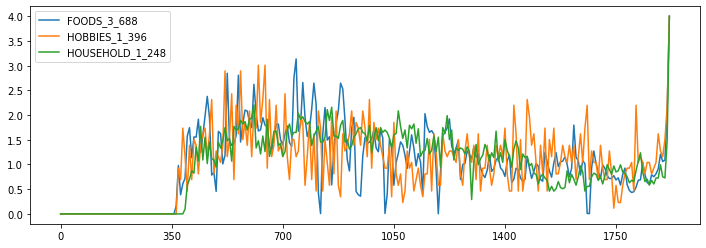

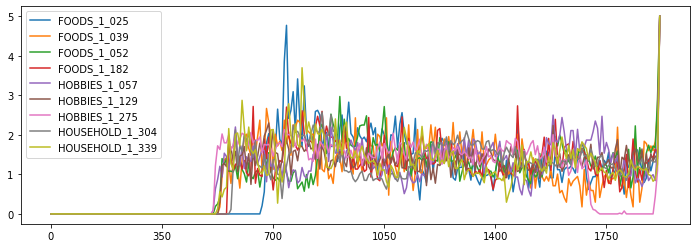

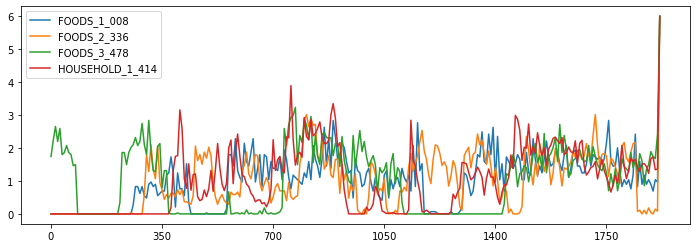

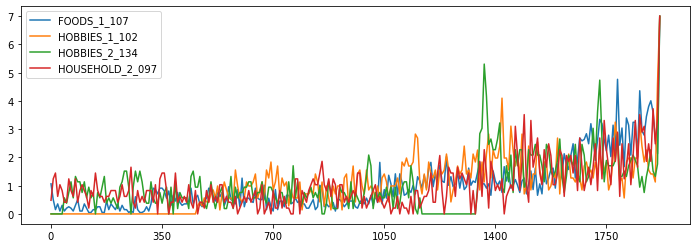

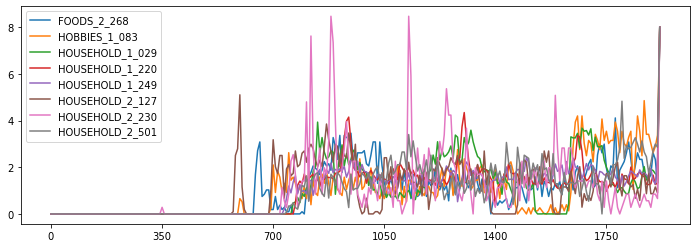

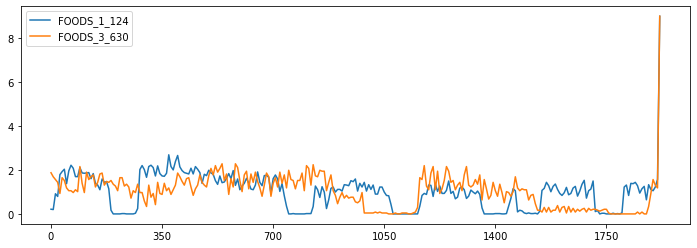

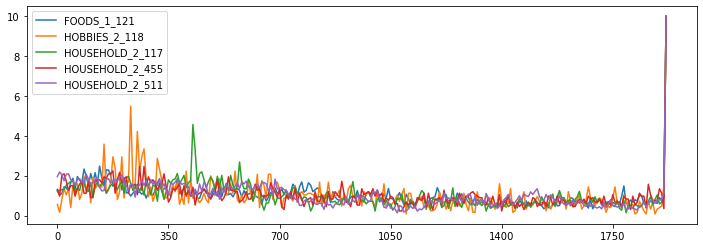

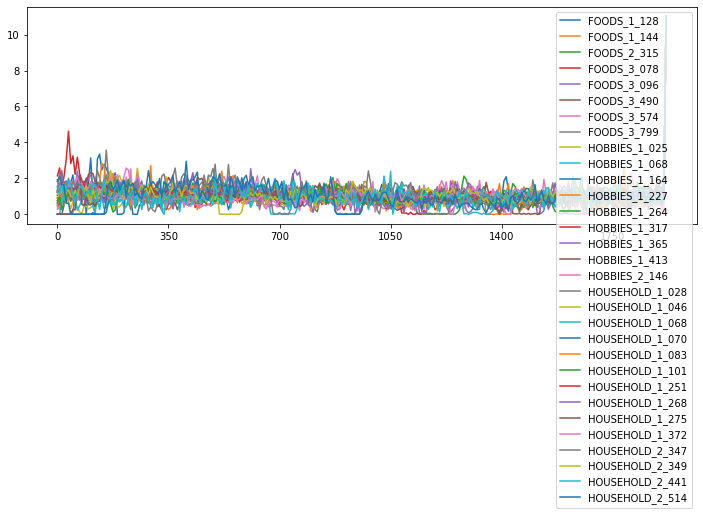

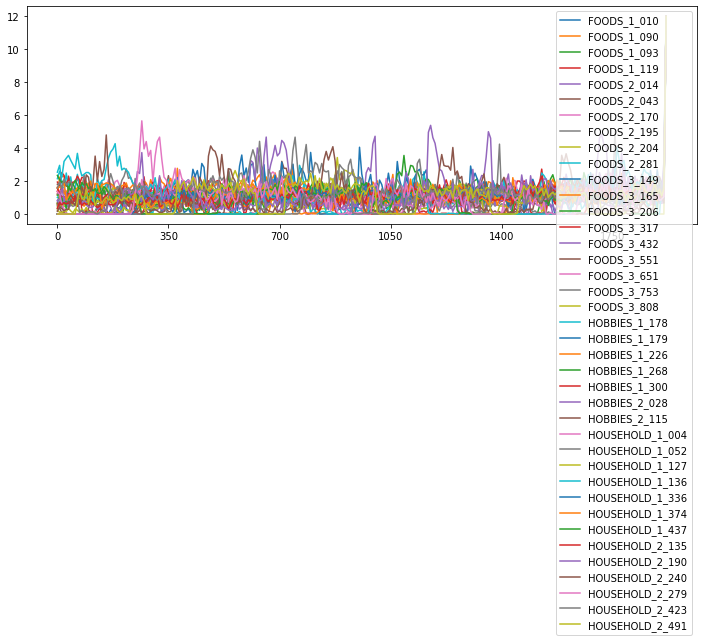

In [54]:

for i in range(1, 13):

    daily_sales_item_lookup_scaled_weekly.T.merge(
        dtw_clusters.loc[dtw_clusters.cluster == i], 
        left_index = True,
        right_index = True
    )\
        .T\
        .plot(figsize = (12,4))

We can see that what the series in this cluster have in common is that they have intermittent of no sales, followed by periods of stable sales. 

Showing the series pair-wise makes this clearer:

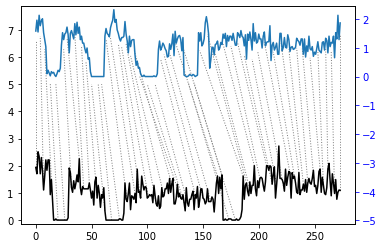

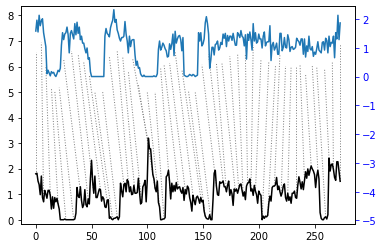

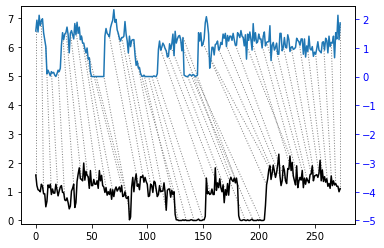

In [31]:
def plot_dtw(series1:str, series2:str) -> None:
    dtw(daily_sales_item_lookup_scaled_weekly[series1],\
            daily_sales_item_lookup_scaled_weekly[series2],\
        keep_internals=True, 
        step_pattern=rabinerJuangStepPattern(2, "c"))\
        .plot(type="twoway",offset=5)

plot_dtw("FOODS_1_119", "HOUSEHOLD_2_423")
plot_dtw("FOODS_2_043", "HOUSEHOLD_2_423")
plot_dtw("HOBBIES_1_300", "HOUSEHOLD_2_423")


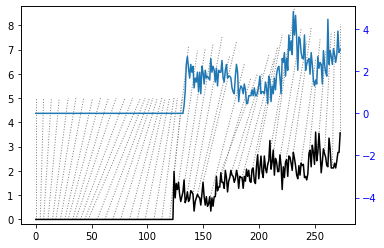

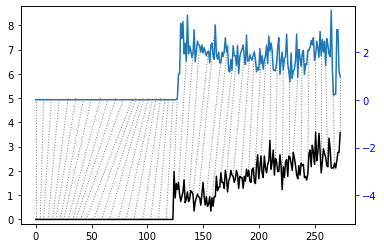

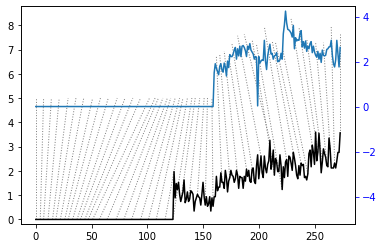

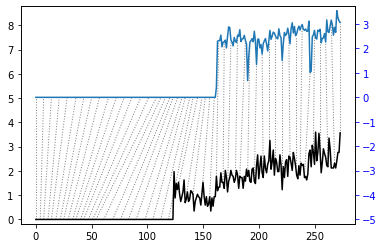

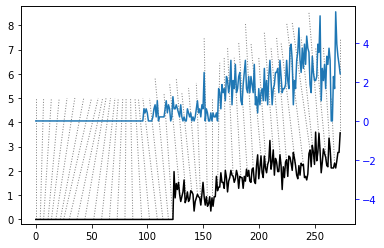

In [33]:
# see which items are in cluster 5
plot_dtw("FOODS_3_247", "FOODS_3_284")
plot_dtw("FOODS_3_247", "HOBBIES_1_122")
plot_dtw("FOODS_3_247", "HOUSEHOLD_1_164")
plot_dtw("FOODS_3_247", "HOUSEHOLD_1_429")
plot_dtw("FOODS_3_247", "HOUSEHOLD_2_318")